In [44]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import numpy as np
from os import listdir
import random

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [45]:
DATASET_FOLDER = "./digits"
DEFAULT_IMAGE_SIZE = (28, 28)
INIT_LR = 1e-3
EPOCHS = 15
BATCH_SIZE = 32

def convert_image_to_array(image_src):
    try:
        image = cv.imread(image_src, cv.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv.resize(image, DEFAULT_IMAGE_SIZE)
            # imageMasked = mask_image(image)
            imgToArray = keras.utils.img_to_array(image) / 255.0
            # print(imgToArray)
            return imgToArray
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [33]:
image_list, label_list = [], []
data = []
try:
    print("[INFO] Loading images ...")
    
    data_dir = listdir(f"{DATASET_FOLDER}")
    
    for eachDirectory in data_dir:
        print(f"[INFO] Processing {eachDirectory} ...")
        plant_disease_image_list = listdir(f"{DATASET_FOLDER}/{eachDirectory}/")
        # print(plant_disease_image_list)
        for image in plant_disease_image_list[50:300]:
            image_directory = f"{DATASET_FOLDER}/{eachDirectory}/{image}"
            label = eachDirectory
            if image_directory.lower().endswith(".jpg") == True:
                # Converting each image into matrix
                arrayImage = convert_image_to_array(image_directory)
                # Adding the images, then labels to list
                image_list.append(arrayImage)
                label_list.append(label)
                # adding both image and label to data
                data.append([arrayImage, label])
    # print(image_list)
    print("\n[INFO] Image loading completed")
    print("\n[INFO] Total Images: ", len(data))
except Exception as e:
    print(f"Error : {e}")


# =================================================================================================
# Shuffle the data to remove bias towards any single sub-dataset
random.shuffle(data)

X = []
Y = []
print(np.shape(data))
for features, labels in data:
    X.append(features)  # X is images
    Y.append(labels)  # Y is labels
images_count = len(X)

X = np.array(X)
Y = np.array(Y)

[INFO] Loading images ...
[INFO] Processing 9 ...
[INFO] Processing 0 ...
[INFO] Processing 7 ...
[INFO] Processing 6 ...
[INFO] Processing 1 ...
[INFO] Processing 8 ...
[INFO] Processing 4 ...
[INFO] Processing 3 ...
[INFO] Processing 2 ...
[INFO] Processing 5 ...

[INFO] Image loading completed

[INFO] Total Images:  2500
(2500, 2)


/Users/debkanchan/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [34]:
# image_list = X
# label_list = Y
# print(np.shape(image_list))
# label_binarizer = LabelBinarizer()
# image_labels = label_binarizer.fit_transform(label_list)
# n_classes = len(label_binarizer.classes_)
# print(n_classes)

(2500, 28, 28, 1)
10


In [35]:
# np_image_list = np.array(image_list, dtype=np.float16) / 225.0


# # ====================================================================================================
# print("[INFO] Spliting data to train, test")
# x_train, x_test, y_train, y_test = train_test_split(
#     np_image_list, image_labels, test_size=0.2, random_state=42
# )

[INFO] Spliting data to train, test


Import Dataset

In [47]:
import tensorflow_datasets as tfds

(ds_train, ds_val), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(128)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

Build CNN

In [48]:
# ====================================================================================================
# inputShape = (height, width, depth)
inputShape = (28, 28, 1)
chanDim = -1
if keras.backend.image_data_format() == "channels_first":
    # inputShape = (depth, height, width)
    inputShape = (1, 28, 28)
    chanDim = 1
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=inputShape),
    # keras.layers.BatchNormalization(axis=chanDim),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    # keras.layers.Dropout(0.25),

    # keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
    # keras.layers.BatchNormalization(axis=chanDim),

    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
    # keras.layers.BatchNormalization(axis=chanDim),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation="relu"),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(n_classes, activation="softmax")
])

In [52]:
# ====================================================================================================
model.summary()
# ====================================================================================================
# opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
# loss = keras.losses.categorical_crossentropy
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# train the network
print("[INFO] training network...")


# ====================================================================================================
history = model.fit(
    # aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
    # x = x_train,
    # y = y_train,
    ds_train,
    validation_data=ds_val,
    # steps per epoch? not a fixed number like 16 or 32?
    # steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=5,
    # validation_split=0.2,
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 9, 9, 128)         36992     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)             

Plot Accuracy

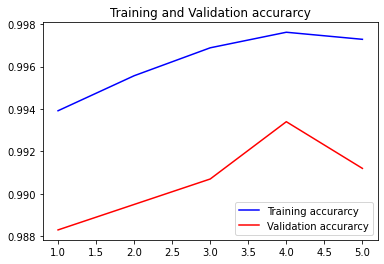

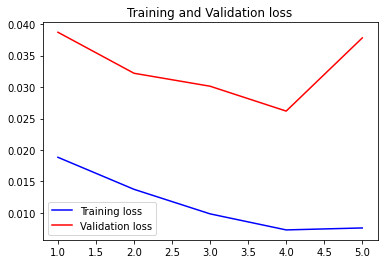

In [54]:
import numpy as np
from matplotlib import pyplot as plt

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
# Train and validation accuracy
plt.plot(epochs, acc, "b", label="Training accurarcy")
plt.plot(epochs, val_acc, "r", label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

plt.figure()
# Train and validation loss
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 66ms/step
why dont you model some bitches

Predicted value for ./digits/6/img_21.jpg --- Predicted Class [6] --- Result [[2.5686920e-06 4.6513678e-12 4.2399612e-13 3.2070052e-13 1.1382826e-08
  5.4784988e-07 9.9999678e-01 9.5237266e-18 6.2153735e-09 1.6197254e-13]]


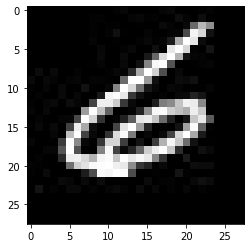

In [55]:
loaded_model = model

path = "./digits/6/img_21.jpg"
# img = load_img(path, target_size=(28,28), color_mode="grayscale")
# i = img_to_array(img)
# im = keras.applications.vgg19.preprocess_input(i)
# img = np.expand_dims(im, axis=0)
matrix = convert_image_to_array(path)
img = np.expand_dims(matrix, axis=0)

result = loaded_model.predict(img)
predictedClass = [np.argmax(element) for element in result]

# print(predictedClass[0])
image = cv.imread(path)
plt.imshow(image)
print("why dont you model some bitches")
print(f"\nPredicted value for {path} --- Predicted Class {predictedClass} --- Result {result}")

In [51]:
loaded_model = model


def predict(src):
    path = src
    img = keras.utils.load_img(path, target_size=(28,28))
    img_matrix = convert_image_to_array(path)
    toBePredictedImage = np.expand_dims(img_matrix, axis=0)
    
    result = loaded_model.predict(toBePredictedImage)
    predictedClass = [np.argmax(element) for element in result]
    image_folder = path[9:10]
    boolResult = False
    if str(image_folder) == str(predictedClass[0]):
        boolResult = True
    # print(f"\nPredicted value for {path} --- Predicted Class {predictedClass} --- Result {result} --- Correct???? {boolResult}")
    return boolResult

test_set = []
correct_results = 0
wrong_results = 0
for eachDirectory in listdir(f"{DATASET_FOLDER}"):
    plant_disease_image_list = listdir(f"{DATASET_FOLDER}/{eachDirectory}/")
    for image in plant_disease_image_list[1:100]:
        test_set.append(f"{DATASET_FOLDER}/{eachDirectory}/{image}")
random.shuffle(test_set)
for image in test_set:
    result = predict(image)
    if(result==True):
        correct_results += 1
    else:
        wrong_results += 1
print("correct_results ---> ",correct_results,"    wrong_results ---> ",wrong_results)

1/1 [==============================] - 0s 12ms/step
correct_results --->  984     wrong_results --->  6
